In [2]:
!pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 31.9 MB/s eta 0:00:00


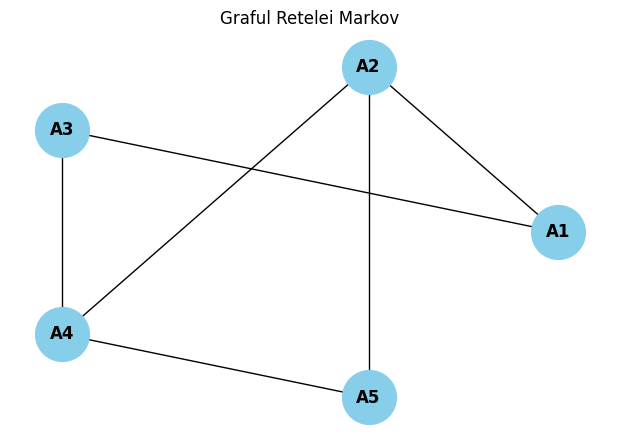


Clicile: [['A2', 'A5', 'A4'], ['A2', 'A1'], ['A3', 'A1'], ['A3', 'A4']]

+--------+--------+--------+--------+--------+-----------------------+
| A1     | A2     | A3     | A4     | A5     |   phi(A1,A2,A3,A4,A5) |
+========+========+========+========+========+=======================+
| A1(-1) | A2(-1) | A3(-1) | A4(-1) | A5(-1) |                0.0000 |
+--------+--------+--------+--------+--------+-----------------------+
| A1(-1) | A2(-1) | A3(-1) | A4(-1) | A5(1)  |                0.0000 |
+--------+--------+--------+--------+--------+-----------------------+
| A1(-1) | A2(-1) | A3(-1) | A4(1)  | A5(-1) |                0.0000 |
+--------+--------+--------+--------+--------+-----------------------+
| A1(-1) | A2(-1) | A3(-1) | A4(1)  | A5(1)  |                0.0000 |
+--------+--------+--------+--------+--------+-----------------------+
| A1(-1) | A2(-1) | A3(1)  | A4(-1) | A5(-1) |                0.0000 |
+--------+--------+--------+--------+--------+-----------------------+
| A

In [19]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.inference import VariableElimination

# a)
nodes = ['A1', 'A2', 'A3', 'A4', 'A5']
edges = [('A1', 'A2'), ('A1', 'A3'), ('A2', 'A4'), ('A2', 'A5'), ('A3', 'A4'), ('A4', 'A5')]
model = MarkovNetwork(edges)
model.add_nodes_from(nodes)

plt.figure(figsize=(6, 4))
pos = nx.circular_layout(model)
nx.draw(model, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=12, font_weight="bold")
plt.title("Graful Retelei Markov")
plt.show()

cliques = list(nx.find_cliques(model))
print(f"\nClicile: {cliques}\n")

# b)
lista_de_factori = []
for clica in cliques:
    variabile_clica = sorted(clica)
    numar_variabile = len(variabile_clica)

    combinatii = np.array(np.meshgrid(*[[-1, 1]] * numar_variabile)).T.reshape(-1, numar_variabile)
    indici = [int(v[1]) for v in variabile_clica]
    suma_ponderata = np.sum(combinatii * indici, axis=1)
    valori_potential = np.exp(suma_ponderata)

    factor = DiscreteFactor(
        variables=variabile_clica,
        cardinality=[2] * numar_variabile,
        values=valori_potential,
        state_names={v: [-1, 1] for v in variabile_clica}
    )
    lista_de_factori.append(factor)

model.add_factors(*lista_de_factori)

algoritm_inferenta = VariableElimination(model)

joint_distribution_unnormalized = algoritm_inferenta.query(variables=nodes, show_progress=False)

joint_distribution_normalized = joint_distribution_unnormalized.copy()
joint_distribution_normalized.normalize(inplace=True)

print(joint_distribution_normalized)

configuratie_optima = algoritm_inferenta.map_query(show_progress=False)

print(f"\nCOnfiguratia optima: {configuratie_optima}")

Original Image:
[[1 1 0 1 0]
 [0 1 0 1 0]
 [1 0 0 0 0]
 [1 1 1 0 1]
 [0 1 0 0 0]]


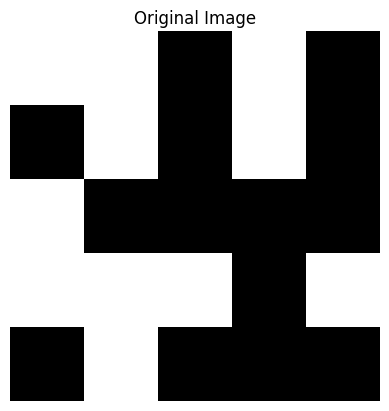

Noisy Image:
[[1 1 0 1 1]
 [0 0 0 1 0]
 [1 0 0 0 0]
 [1 1 1 0 1]
 [0 1 0 0 0]]


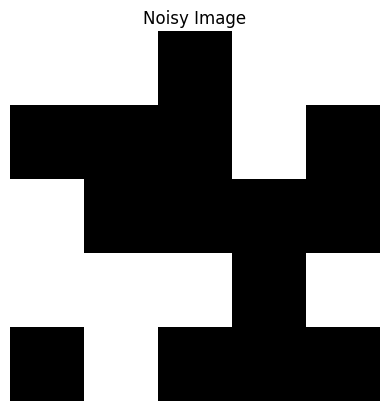

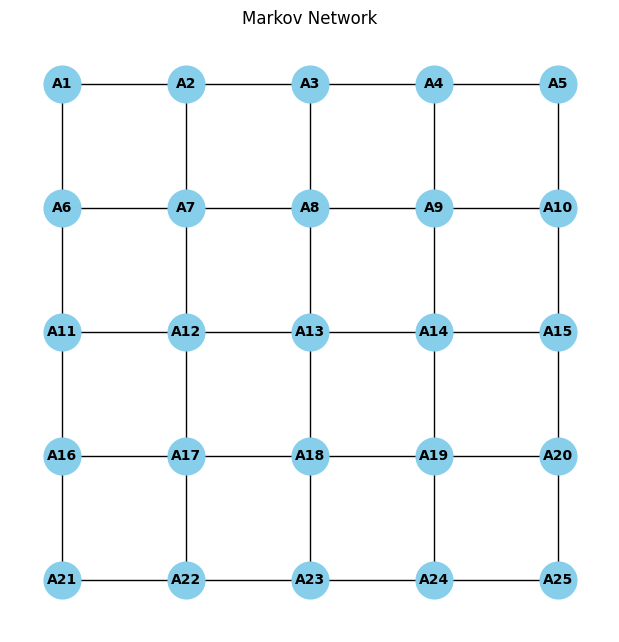

Denoised image data:
[[1. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


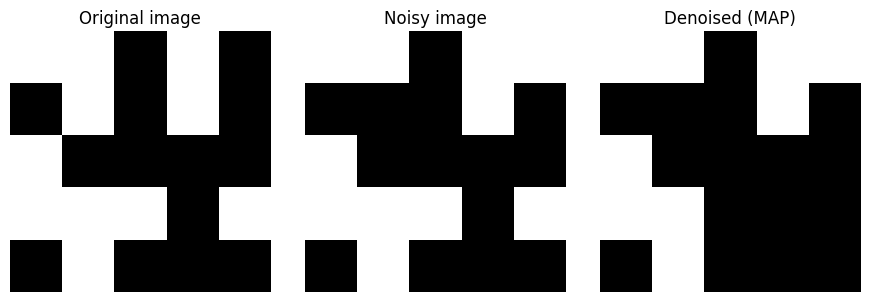

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.inference import BeliefPropagation
import networkx as nx

size = 5
original = np.random.randint(0, 2, (size, size))

print("Original Image:")
print(original)
plt.imshow(original, cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.show()

# Adaugam zgomot
noisy = original.copy()
num_noisy = int(size * size * 0.1)
indices = np.random.choice(size * size, num_noisy, replace=False)
for idx in indices:
    i, j = divmod(idx, size)
    noisy[i, j] = 1 - noisy[i, j]

print("Noisy Image:")
print(noisy)
plt.imshow(noisy, cmap="gray")
plt.title("Noisy Image")
plt.axis("off")
plt.show()
print("\n\n")

model = MarkovNetwork()

nodes = [(i, j) for i in range(size) for j in range(size)]
model.add_nodes_from(nodes)

edges = []
for i in range(size):
    for j in range(size):
        if i < size - 1:
            edges.append(((i, j), (i + 1, j)))
        if j < size - 1:
            edges.append(((i, j), (i, j + 1)))
model.add_edges_from(edges)

plt.figure(figsize=(6, 6))
pos = {(i, j): (j, -i) for i, j in nodes}
node_labels = {node: f'A{k+1}' for k, node in enumerate(nodes)}

nx.draw(model, pos, with_labels=True, labels=node_labels, node_size=700, node_color="skyblue", font_size=10, font_weight="bold")

plt.title("Markov Network")
plt.show()

λ = 2.0
sigma = 1.0

factors = []

for i in range(size):
    for j in range(size):
        y = noisy[i, j]
        values = np.zeros(2)
        for xi in [0, 1]:
            values[xi] = np.exp(-λ * (xi - y) ** 2)
        factor = DiscreteFactor(variables=[(i, j)],
                                cardinality=[2],
                                values=values)
        factors.append(factor)

for (p1, p2) in edges:
    values = np.zeros((2, 2))
    for xi in [0, 1]:
        for xj in [0, 1]:
            values[xi, xj] = np.exp(-sigma * (xi - xj) ** 2)
    factor = DiscreteFactor(variables=[p1, p2],
                            cardinality=[2, 2],
                            values=values)
    factors.append(factor)

model.add_factors(*factors)

bp = BeliefPropagation(model)
map_result = bp.map_query(variables=nodes)

denoised = np.zeros((size, size))
for (i, j), val in map_result.items():
    denoised[i, j] = val

print("Denoised image data:")
print(denoised)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(original, cmap="gray")
axes[0].set_title("Original image")
axes[1].imshow(noisy, cmap="gray")
axes[1].set_title("Noisy image")
axes[2].imshow(denoised, cmap="gray")
axes[2].set_title("Denoised (MAP)")
for ax in axes:
    ax.axis("off")
plt.tight_layout()
plt.show()